<a href="https://colab.research.google.com/github/nshanbhag2003/Deep-Models-NLP-Reinforcement-Learning/blob/main/AML_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q learning for a classic control problem

In [ ]:
!apt install xvfb ffmpeg freeglut3-dev
!pip install imageio
!pip install pyvirtualdisplay
!pip install pyglet
!pip install gymnasium[classic_control]
!pip install moviepy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
The following additional packages will be installed:
  freeglut3 libegl-dev libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev
  libopengl-dev libxt-dev
Suggested packages:
  libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libopengl-dev libxt-dev
0 upgraded, 14 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,192 kB of archives.
After this operation, 6,439 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ub

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import namedtuple, deque
import random

## Implementing DQN for the Cartpole Problem

### The Cartpole Environment

In [ ]:
# Load the cartpole environment
env = gym.make('CartPole-v1')

# Get the number of actions and the dimension of the observation space
num_actions = env.action_space.n
state_shape = env.observation_space.shape
print(f"Actions: {num_actions}, State Shape: {state_shape}")

Actions: 2, State Shape: (4,)


In [ ]:
# Define the neural network model
class QModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, num_actions):
        super(QModel, self).__init__()
        layers_list = []
        layers_list.append(nn.Linear(input_dim, layer_sizes[0]))
        layers_list.append(nn.ReLU())
        for i in range(1, len(layer_sizes) - 1):
            layers_list.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            layers_list.append(nn.ReLU())
        layers_list.append(nn.Linear(layer_sizes[-1], num_actions, bias=False))
        self.model = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.model(x)

# Function to create Q models
def create_q_models(input_dim, layer_sizes, num_actions, do_target=False):
    model = QModel(input_dim, layer_sizes, num_actions)
    if do_target:
        target = QModel(input_dim, layer_sizes, num_actions)
        target.load_state_dict(model.state_dict()) # Sync weights initially
        target.eval() # Set target to evaluation mode
        return model, target
    return model

# Architecture for our feedforward nets
layer_sizes = [32, 32, 32]

# Initialize Q models
model = create_q_models(state_shape[0], layer_sizes, num_actions)
model_target = create_q_models(state_shape[0], layer_sizes, num_actions)  # For simplicity, in this case, the target model is the same as the main model

In [ ]:
# Define ReplayMemory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# -- Parameters
# Discount factor for past rewards
gamma = 0.99

# Epsilon-greedy decay parameters
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter

# This is the number of frames it will take to go from min to max epsilon
# Controls the rate of change of epsilon.
epsilon_greedy_frames = 20_000
epsilon_interval = epsilon_max - epsilon_min

# Size of each training batch
batch_size = 32

# Make sure episodes don't last forever
max_steps_per_episode = 10000

# Train the model after 4 actions -- learning every step is slow and unstable.
update_after_actions = 4

# Other losses are sometimes used in DQNs (e.g. Huber for Atari)
loss_function = nn.MSELoss()

### Q1-3: Complete the following codes according to the pseudoalgorithm.

running reward: 19.39 at episode 51, frame count 1000, greedy prob 0.04500000000000004, time spent so far 0.02m
Making plots after 100 episodes


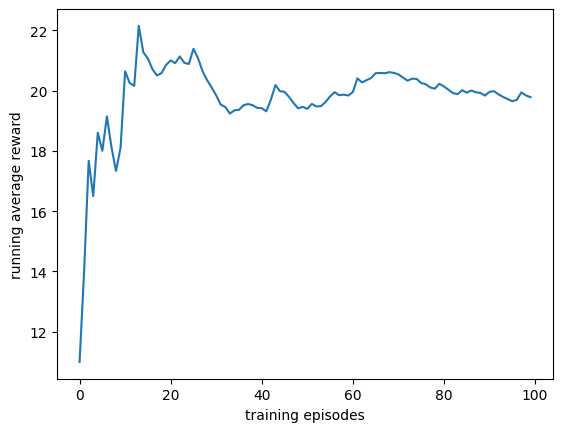

running reward: 19.78 at episode 100, frame count 2000, greedy prob 0.08999999999999997, time spent so far 0.04m
running reward: 20.75 at episode 144, frame count 3000, greedy prob 0.135, time spent so far 0.06m
running reward: 22.52 at episode 187, frame count 4000, greedy prob 0.17999999999999994, time spent so far 0.07m
Making plots after 200 episodes


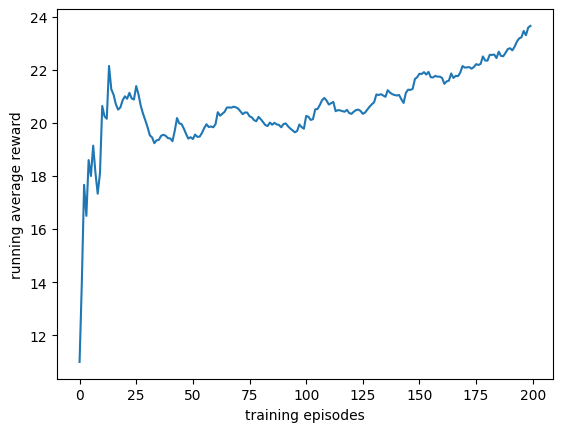

running reward: 25.43 at episode 220, frame count 5000, greedy prob 0.22499999999999998, time spent so far 0.08m
running reward: 27.27 at episode 255, frame count 6000, greedy prob 0.27, time spent so far 0.09m
running reward: 30.18 at episode 285, frame count 7000, greedy prob 0.31499999999999995, time spent so far 0.09m
Making plots after 300 episodes


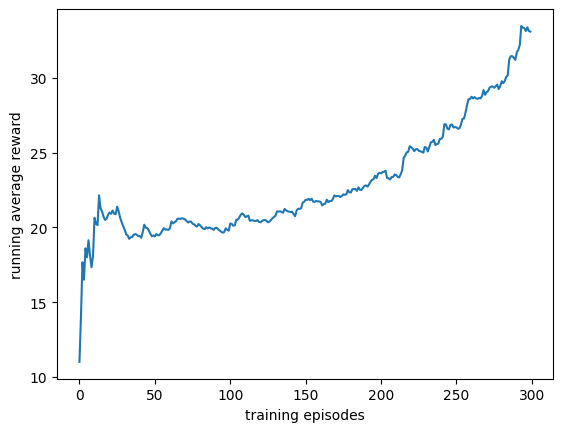

running reward: 32.78 at episode 311, frame count 8000, greedy prob 0.36, time spent so far 0.10m
running reward: 37.78 at episode 330, frame count 9000, greedy prob 0.405, time spent so far 0.11m
running reward: 42.89 at episode 346, frame count 10000, greedy prob 0.44999999999999996, time spent so far 0.11m
running reward: 47.55 at episode 360, frame count 11000, greedy prob 0.495, time spent so far 0.12m
running reward: 53.76 at episode 372, frame count 12000, greedy prob 0.54, time spent so far 0.13m
running reward: 61.41 at episode 381, frame count 13000, greedy prob 0.585, time spent so far 0.13m
running reward: 68.12 at episode 388, frame count 14000, greedy prob 0.63, time spent so far 0.14m
running reward: 75.74 at episode 393, frame count 15000, greedy prob 0.675, time spent so far 0.15m
Making plots after 400 episodes


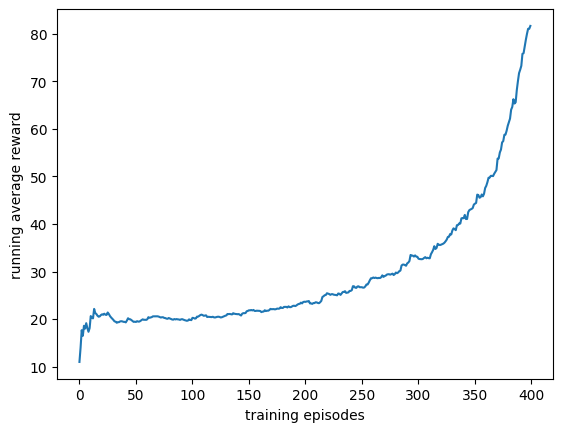

running reward: 81.61 at episode 400, frame count 16000, greedy prob 0.72, time spent so far 0.16m
running reward: 90.96 at episode 403, frame count 17000, greedy prob 0.765, time spent so far 0.16m
Making plots after 407 episodes


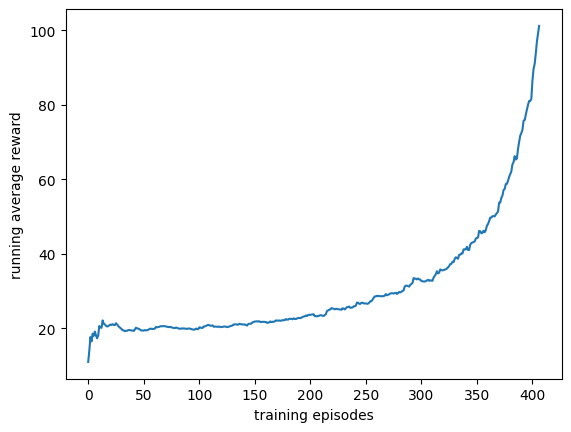

Solved at episode 407!


In [ ]:
# Set seed
random.seed(42)
rng = np.random.default_rng(42)

# Initialize optimizer
optimizer = optim.Adam(model.parameters())

# Initialize memory, but with max capacity equal to batch_size.
memory = ReplayMemory(batch_size)

log_interval = 1000
running_reward = 0
episode_count = 0
frame_count = 0
epsilon = epsilon_max
episode_reward_history = []
running_reward_history = []
# track the time spent training
tic = time.time()

# Run until solved
while True:
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Decay probability of taking random action
        # Q1: Implement epsilon decay
        # Epsilon should decay linearly from epsilon_max to epsilon_min
        # starting at epsilon_max when `frame_count==0`, and ending at
        # epsilon_min when `frame_count==epsilon_greedy_frames`.

        ### Your code here ##
        if frame_count < epsilon_greedy_frames:
          epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
          epsilon = epsilon_min

        # Use epsilon-greedy for exploration
        # Q2: implement epsilon greedy.
        # With probability epsilon, set action to a randomly chosen action
        # Else, use the best action according to model (not target_model).
        ### Your code here ##
        if random.random() < epsilon:
          action = env.action_space.sample()
        else:
          with torch.no_grad():
            q_values = model(state.unsqueeze(0))
            action = torch.argmax(q_values).item()


        state_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        # Convert to tensors before pushing to memory
        state_next = torch.tensor(state_next, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float32)
        done_tensor = torch.tensor(done, dtype=torch.float32)

        # Store the transition in memory
        memory.push(state, action, state_next, reward, done_tensor)
        state = state_next

        if frame_count % update_after_actions == 0 and len(memory) == batch_size:
            # This is the "no-replay" part: we just use the *entire* buffer
            transitions = list(memory.memory)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            # Q3: Computing the DQN loss.
            # We will break this into 3 steps.

            # Q3.a: use model to predict the Q values at the minibatch of next
            # states, `next_state_batch`.
            # Since we are not using a target network, this is slightly different
            # from the Qhat(s', a') in the pseudocode above: use the model,
            # not model_target, to predict Q.

            ### Your code here ##
            with torch.no_grad():
              next_q_values = model(next_state_batch)

            # Q3.b: Find the maximum reward at these future states
            # This corresponds to max_{a'} Qhat(s', a') in the pseudocode above
            # Take the maximum over actions of Q_hat

            ### Your code here ##
            max_next_q_values, _ = torch.max(next_q_values, dim=1)

            # Q3.c: Compute the target y in the loss
            # target = (reward at this sample) + (discount factor) * (optimal reward at future sample)
            # This corresponds to y_i in the pseudocode above.

            ### Your code here ##
            target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            optimizer.zero_grad()
            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)
            loss = loss_function(q_action, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if not frame_count % log_interval:
            toc = time.time()
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}, time spent so far {:.2f}m"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon, (toc - tic) / 60))

        if done:
            break

    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print("Making plots after", episode_count, "episodes")
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

### Q4: Train again with experience replay and the target network

In [ ]:
## -- Experience replay and target model logic
# Maximum replay length
# Note: The Deepmind Atari paper suggests 1000000 however this causes memory issues
max_memory_length = 100000

# How often to update the target network
update_target_network = 1000

# Create a new model so that we can train from scratch
# Also initialize a target model with the same architecture
model, model_target = create_q_models(state_shape[0], layer_sizes, num_actions, do_target=True)

running reward: 20.62 at episode 48, frame count 1000, greedy prob 0.04500000000000004
running reward: 20.98 at episode 95, frame count 2000, greedy prob 0.08999999999999997
100


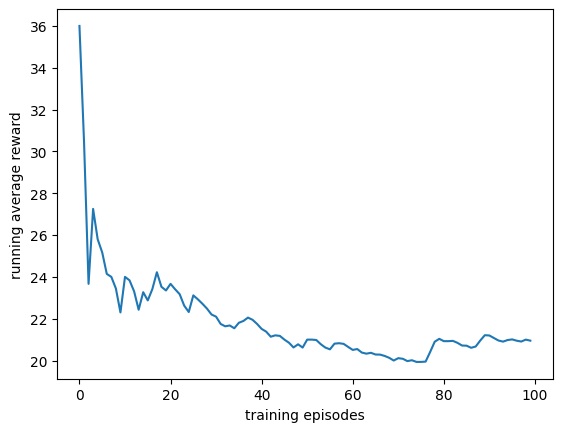

running reward: 21.03 at episode 140, frame count 3000, greedy prob 0.135
running reward: 24.47 at episode 177, frame count 4000, greedy prob 0.17999999999999994
200


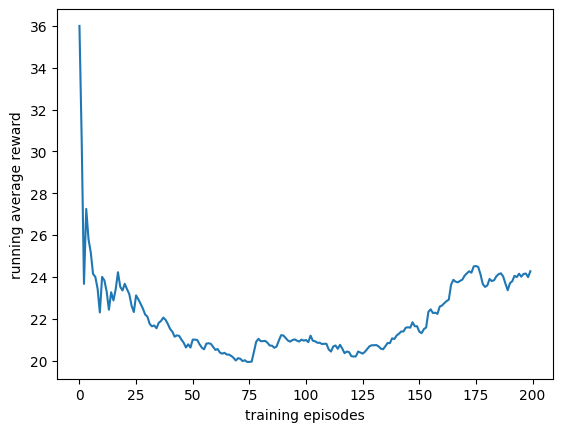

running reward: 25.28 at episode 218, frame count 5000, greedy prob 0.22499999999999998
running reward: 29.26 at episode 244, frame count 6000, greedy prob 0.27
running reward: 32.23 at episode 269, frame count 7000, greedy prob 0.31499999999999995
running reward: 37.29 at episode 286, frame count 8000, greedy prob 0.36
300


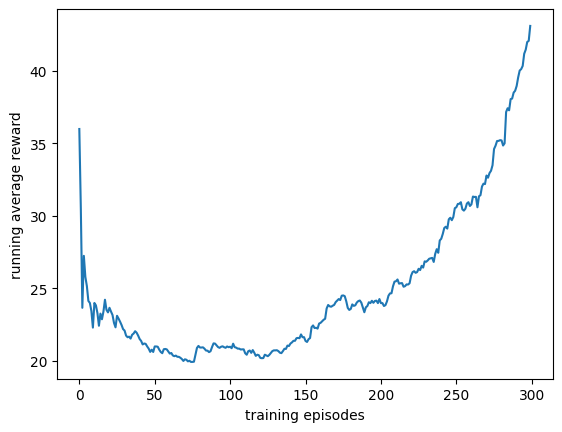

running reward: 44.03 at episode 303, frame count 9000, greedy prob 0.405
running reward: 51.20 at episode 311, frame count 10000, greedy prob 0.44999999999999996
running reward: 57.40 at episode 322, frame count 11000, greedy prob 0.495
running reward: 65.41 at episode 329, frame count 12000, greedy prob 0.54
running reward: 73.58 at episode 337, frame count 13000, greedy prob 0.585
running reward: 79.63 at episode 345, frame count 14000, greedy prob 0.63
running reward: 85.21 at episode 350, frame count 15000, greedy prob 0.675
running reward: 96.10 at episode 354, frame count 16000, greedy prob 0.72
357


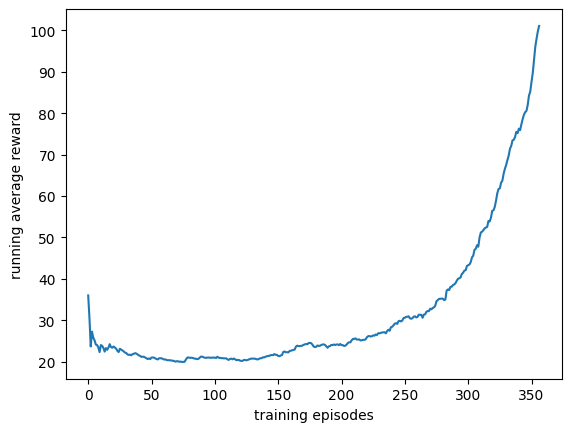

Solved at episode 357!


In [ ]:
# Set seed
random.seed(42)
rng = np.random.default_rng(42)

# -- Initialize training loop variables
optimizer = optim.Adam(model.parameters())

# Experience replay buffer
memory = ReplayMemory(max_memory_length)

# reset histories and counters
running_reward = 0
episode_count = 0
frame_count = 0
episode_reward_history = []
running_reward_history = []

# epsilon for epsilon-greedy. will be modified in the training loop.
epsilon = epsilon_max

# Run until solved
while True:
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    episode_reward = 0

    # Episode loop
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Decay probability of taking random action
        # Q4.a: Implement epsilon decay
        # This code should be exactly the same as your code above in Q1
        ### Your code here ##
        if frame_count < epsilon_greedy_frames:
          epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
          epsilon = epsilon_min

        # Use epsilon-greedy for exploration
        # Q4.b: implement epsilon greedy.
        # This code should be exactly the same as your code above in Q2
        ### Your code here ##
        if random.random() < epsilon:
          action = env.action_space.sample()
        else:
          with torch.no_grad():
            q_values = model(state.unsqueeze(0))
            action = torch.argmax(q_values).item()

        # Apply the sampled action in our environment
        state_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        episode_reward += reward

        # Convert to tensors and store in replay buffer
        state_next = torch.tensor(state_next, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float32)
        done_tensor = torch.tensor(done, dtype=torch.float32)

        memory.push(state, action, state_next, reward, done_tensor)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(memory) > batch_size:
            # Sample a random batch from the replay buffer
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            # Computing the DQN loss.
            # We will break this into 3 steps.

            # Q4.c: Predicting Q values
            # <!> This requires some changes from above! <!>
            # Rather than using `model`, use `model_target` to predict the Q
            # values at the minibatch of next states, `state_next_sample`.
            # This is exactly Qhat(s', a') in the pseudocode above
            ### Your code here ##
            with torch.no_grad():
              next_q_values = model_target(next_state_batch)

            # Q4.d: Find the maximum reward at these future states
            # This should be the same as your code above.
            ### Your code here ##
            max_next_q_values, _ = torch.max(next_q_values, dim=1)

            # Q4.e: Compute the target y in the loss
            # This should be the same as your code above.
            ### Your code here ##
            target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            optimizer.zero_grad()
            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)

            # Calculate loss between new Q-value and old Q-value
            loss = loss_function(q_action, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if frame_count % update_target_network == 0:
            # update the target network with new weights
            model_target.load_state_dict(model.state_dict())

            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon))

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print(episode_count)
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    # Condition to consider the task solved
    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

### Q5. Why does experience replay help?

**YOUR ANSWER HERE:**

Experience replay helps because it breaks the correlation between consecutive transitions in reinforcement learning. By storing past experiences and sampling them randomly, the training data becomes more like i.i.d. samples, which is a key assumption for supervised learning algorithms. This stabilizes training and prevents the network from overfitting to recent experiences.


### Q6. Why does (freezing ) the target network help?

**YOUR ANSWER HERE:**

Freezing the target network helps stabilize training in Q-learning by providing a fixed reference for the Q-value updates. Since the loss function compares the predicted Q-values with target Q-values, using a frozen network prevents the targets from changing every step, reducing harmful correlations. This allows the main network to learn more reliably without relying on a constantly moving target.


### Visualizing the trained model!

In [ ]:
# --- Animate the Trained Agent ---

from pyvirtualdisplay import Display
from gymnasium.wrappers import RecordVideo


# Start virtual display
display = Display(visible=0, size=(400, 300))
display.start()

# Create a new environment, this time with video recording
# We'll use the fully trained `model` (with ER and TN)
video_env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "/content/video", episode_trigger=lambda x: True )


# Run 3 episodes
for ep in range(3):
    state, info = video_env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    total_reward = 0
    print("Recording video...")

    for _ in range(500): # Run for 500 steps
        # Use a purely greedy policy (no epsilon)
        with torch.no_grad():
            action = model(state).argmax().item()

        state, reward, terminated, truncated, _ = video_env.step(action)
        state = torch.tensor(state, dtype=torch.float32)
        total_reward += reward

        if terminated or truncated:
            break

    print(f"Video finished. Total reward: {total_reward}")

    video_env.close()

Recording video...
Video finished. Total reward: 180.0


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Recording video...
Video finished. Total reward: 168.0
Recording video...
Video finished. Total reward: 270.0


In [ ]:
# --- To display the video in Colab ---
from IPython.display import HTML
from base64 import b64encode

video_path = "/content/video/rl-video-episode-0.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

In [ ]:
video_path = "/content/video/rl-video-episode-1.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

In [ ]:
video_path = "/content/video/rl-video-episode-2.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

### Q7: Changing the reward and revisualizing

Episode 50, Running Reward: -10.000, Epsilon: 0.764


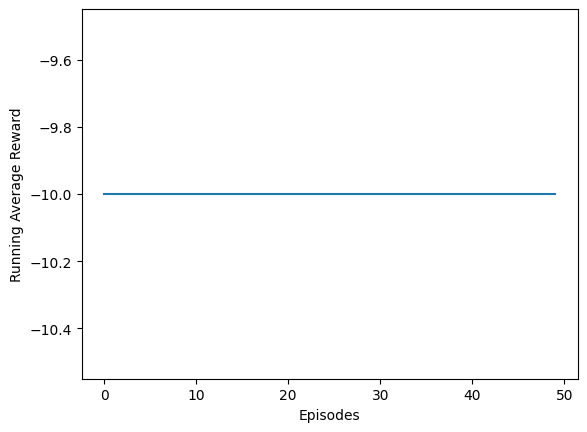

Episode 100, Running Reward: -10.000, Epsilon: 0.465


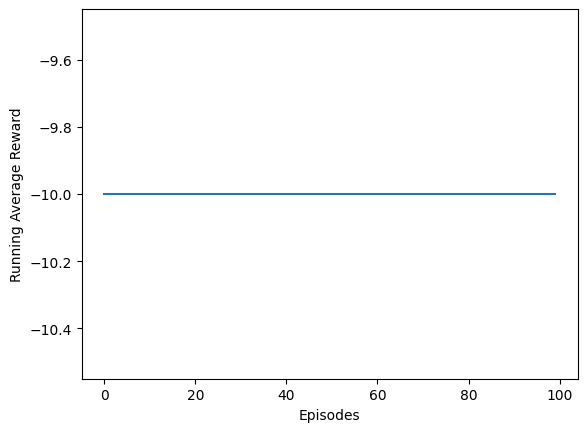

Episode 150, Running Reward: -9.900, Epsilon: 0.100


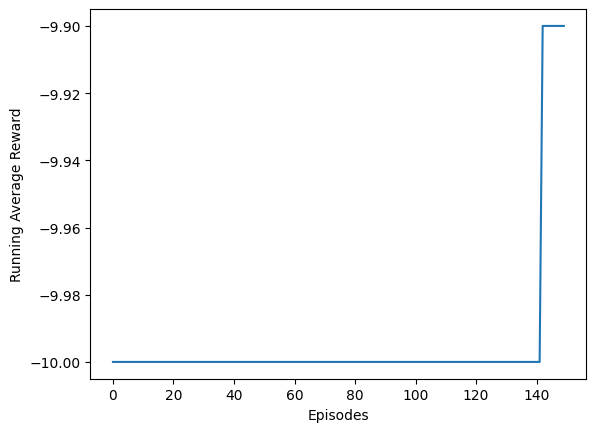

Episode 200, Running Reward: -9.300, Epsilon: 0.100


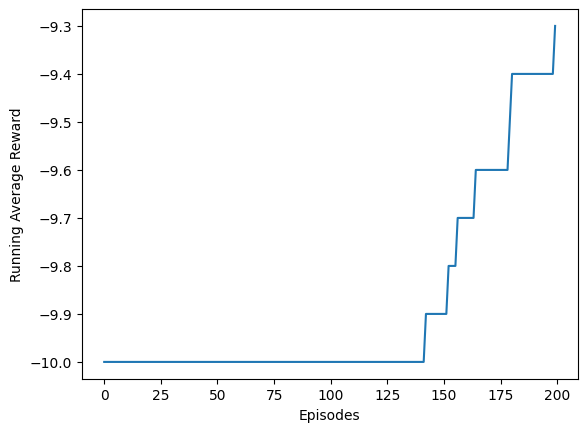

Episode 250, Running Reward: -9.000, Epsilon: 0.100


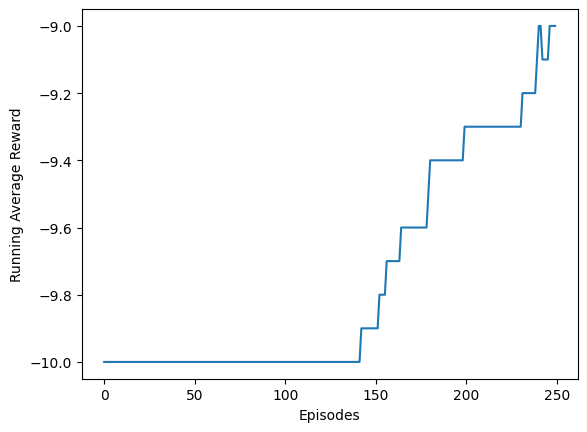

Episode 300, Running Reward: -7.400, Epsilon: 0.100


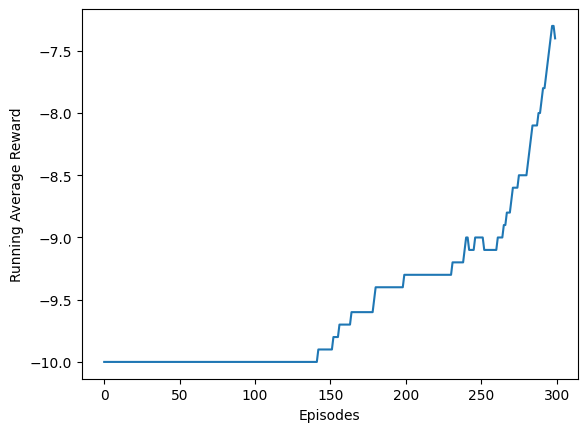

Episode 350, Running Reward: -4.200, Epsilon: 0.100


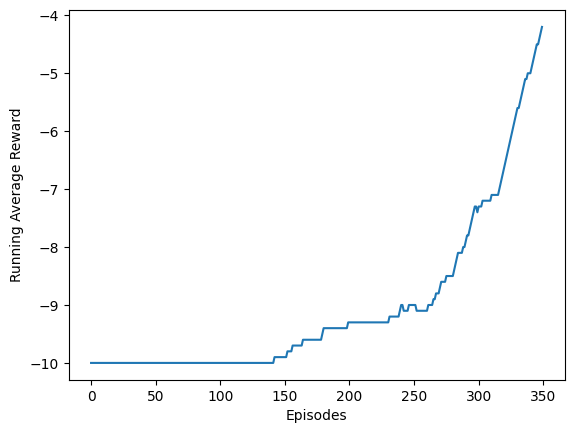

Episode 400, Running Reward: -1.800, Epsilon: 0.100


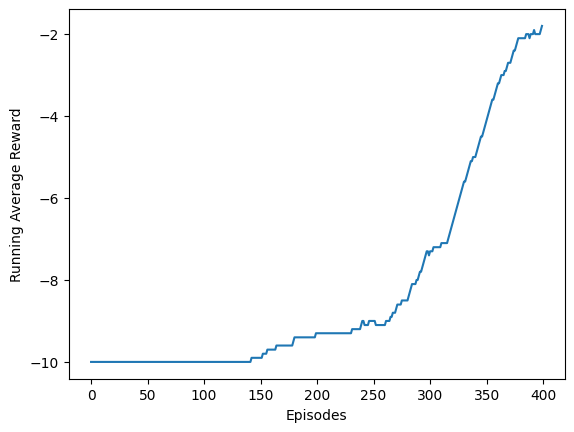

Episode 450, Running Reward: -0.700, Epsilon: 0.100


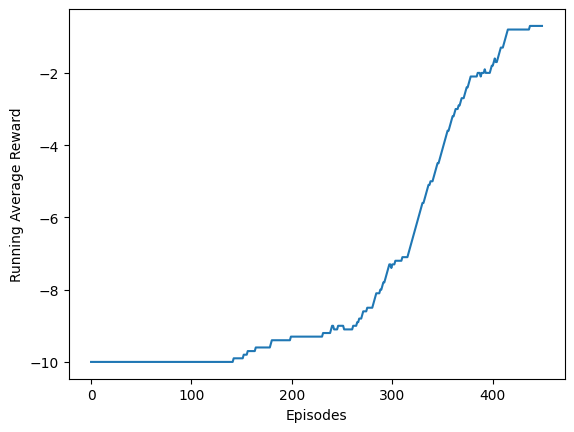

Episode 500, Running Reward: -1.300, Epsilon: 0.100


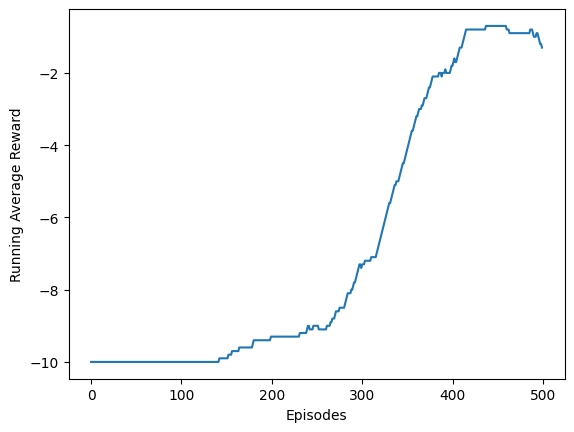

Episode 550, Running Reward: -1.500, Epsilon: 0.100


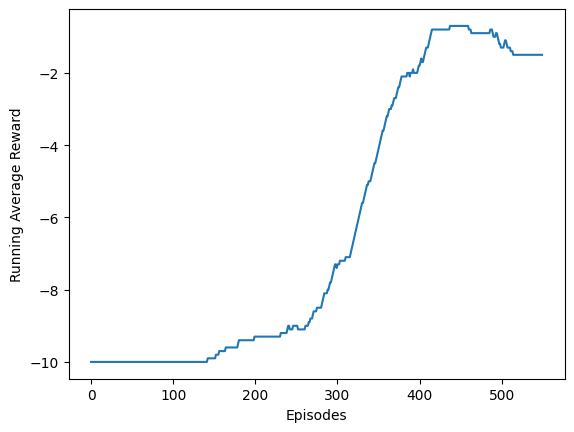

Episode 600, Running Reward: -0.600, Epsilon: 0.100


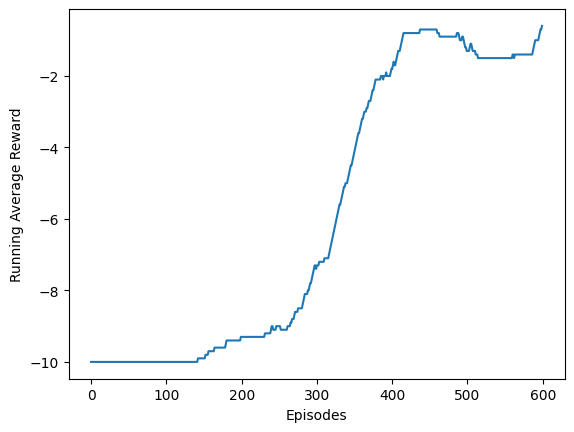

Episode 608, Running Reward: -0.400, Epsilon: 0.100


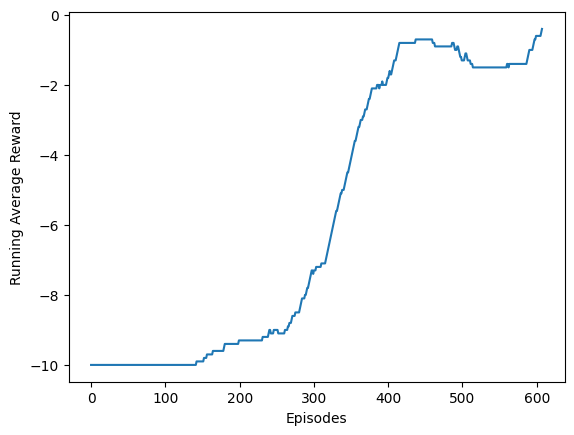

Solved at episode 608!


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Create CartPole environment with Sutton-Barto rewards
env = gym.make("CartPole-v1", sutton_barto_reward=True)

# Hyperparameters
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n
layer_sizes = [64, 64, 64]      # Slightly bigger network
gamma = 0.99
epsilon_max = 1.0
epsilon_min = 0.1
epsilon_greedy_frames = 5000     # Faster decay
epsilon_interval = epsilon_max - epsilon_min
batch_size = 32
update_after_actions = 4
update_target_network = 1000
max_steps_per_episode = 500
max_memory_length = 10000
learning_rate = 1e-4             # Lower LR for small rewards

# Replay memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# Q-network
class QModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, num_actions):
        super().__init__()
        layers_list = [nn.Linear(input_dim, layer_sizes[0]), nn.ReLU()]
        for i in range(1, len(layer_sizes)):
            layers_list.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers_list.append(nn.ReLU())
        layers_list.append(nn.Linear(layer_sizes[-1], num_actions, bias=False))
        self.model = nn.Sequential(*layers_list)
    def forward(self, x):
        return self.model(x)

# Initialize model and target
model = QModel(state_dim, layer_sizes, num_actions)
model_target = QModel(state_dim, layer_sizes, num_actions)
model_target.load_state_dict(model.state_dict())
model_target.eval()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.SmoothL1Loss()   # Huber loss

memory = ReplayMemory(max_memory_length)

# Training variables
running_reward = 0
episode_count = 0
frame_count = 0
episode_reward_history = []
running_reward_history = []
epsilon = epsilon_max

tic = time.time()

while True:
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    episode_reward = 0

    for t in range(1, max_steps_per_episode + 1):
        frame_count += 1

        # Epsilon decay
        if frame_count < epsilon_greedy_frames:
            epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
            epsilon = epsilon_min

        # Epsilon-greedy action
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = model(state.unsqueeze(0))
                action = torch.argmax(q_values).item()

        state_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Scale reward for Sutton-Barto
        reward_scaled = reward * 10.0
        episode_reward += reward_scaled

        # Convert to tensors and store in memory
        state_next = torch.tensor(state_next, dtype=torch.float32)
        memory.push(state, torch.tensor(action, dtype=torch.long),
                    state_next, torch.tensor(reward_scaled, dtype=torch.float32),
                    torch.tensor(done, dtype=torch.float32))
        state = state_next

        # Update network
        if frame_count % update_after_actions == 0 and len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            with torch.no_grad():
                next_q_values = model_target(next_state_batch)
                max_next_q_values, _ = torch.max(next_q_values, dim=1)
                target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)
            loss = loss_function(q_action, target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update target network
        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        if done:
            break

    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 50 or running_reward > -0.5:
        print(f"Episode {episode_count}, Running Reward: {running_reward:.3f}, Epsilon: {epsilon:.3f}")
        plt.figure()
        plt.plot(running_reward_history)
        plt.xlabel("Episodes")
        plt.ylabel("Running Average Reward")
        plt.show()
        plt.close("all")

    if running_reward > -0.5:
        print(f"Solved at episode {episode_count}!")
        break

### Bonus! Try solving a harder task: `LunarLander-v3`

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399014 sha256=b9329700a60177862c7c06ffe40a56083b42947f7ef235c4da1a14a291f9c075
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py
Actions: 4, State shape: 8
Episode 10, Running Reward: -113.24, Epsilon: 0.985
Episode 20, Running Reward: -157.96, Epsilon: 0.968
Episode 30, Running Reward: -165.41, Epsilon: 0.951
Episode 40, Running Reward: -161.19, Epsilon: 0.933
Episode 50, Running Reward: -170.10, Epsilon: 0.912


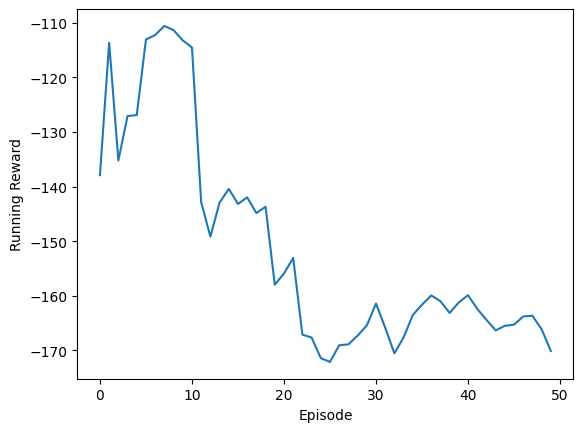

Episode 60, Running Reward: -171.97, Epsilon: 0.893
Episode 70, Running Reward: -162.10, Epsilon: 0.856
Episode 80, Running Reward: -159.23, Epsilon: 0.837
Episode 90, Running Reward: -154.52, Epsilon: 0.815
Episode 100, Running Reward: -151.34, Epsilon: 0.795


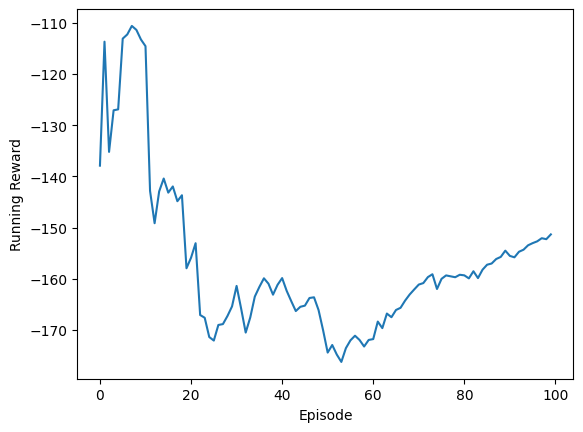

Episode 110, Running Reward: -148.84, Epsilon: 0.759
Episode 120, Running Reward: -138.02, Epsilon: 0.721
Episode 130, Running Reward: -129.41, Epsilon: 0.699
Episode 140, Running Reward: -124.76, Epsilon: 0.679
Episode 150, Running Reward: -108.47, Epsilon: 0.656


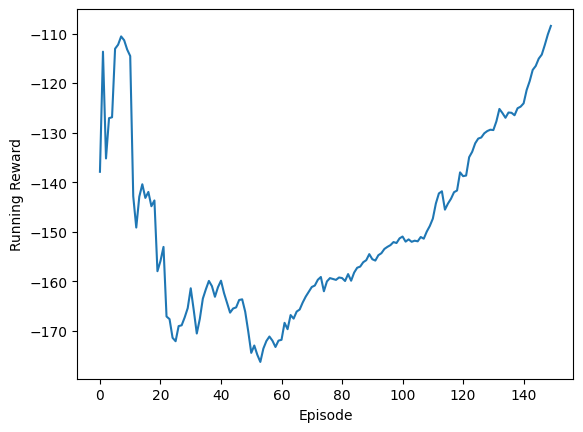

Episode 160, Running Reward: -96.18, Epsilon: 0.635
Episode 170, Running Reward: -91.04, Epsilon: 0.610
Episode 180, Running Reward: -85.15, Epsilon: 0.585
Episode 190, Running Reward: -77.98, Epsilon: 0.559
Episode 200, Running Reward: -67.89, Epsilon: 0.534


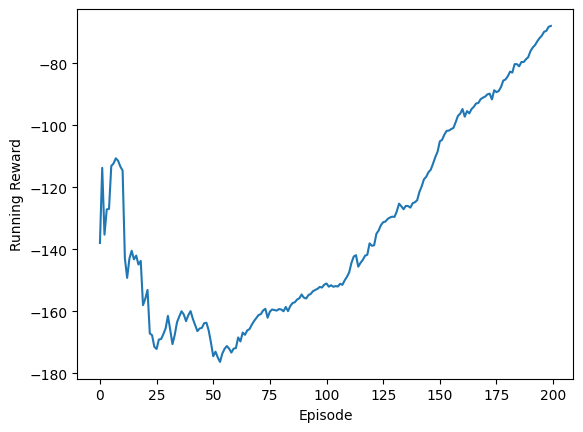

Episode 210, Running Reward: -56.87, Epsilon: 0.441
Episode 220, Running Reward: -55.72, Epsilon: 0.387
Episode 230, Running Reward: -53.55, Epsilon: 0.303
Episode 240, Running Reward: -37.75, Epsilon: 0.187
Episode 250, Running Reward: -31.24, Epsilon: 0.107


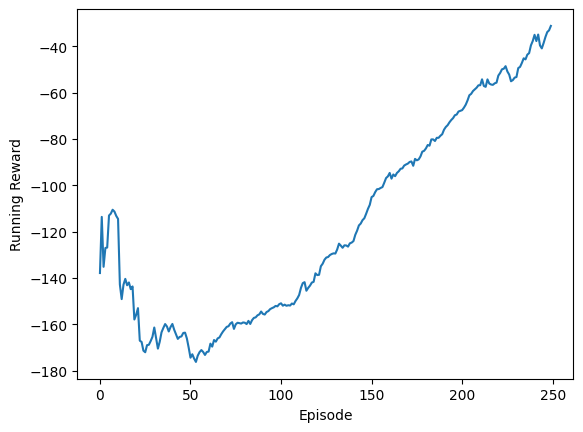

Episode 260, Running Reward: -12.02, Epsilon: 0.050
Episode 270, Running Reward: 5.08, Epsilon: 0.050
Episode 280, Running Reward: 21.87, Epsilon: 0.050
Episode 290, Running Reward: 43.25, Epsilon: 0.050
Episode 300, Running Reward: 59.98, Epsilon: 0.050


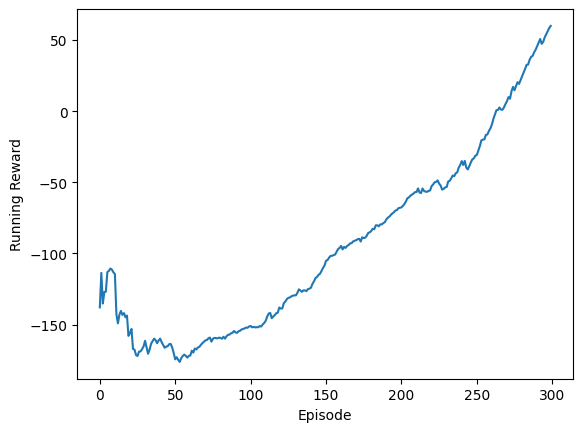

Episode 310, Running Reward: 74.07, Epsilon: 0.050
Episode 320, Running Reward: 103.97, Epsilon: 0.050
Episode 330, Running Reward: 129.47, Epsilon: 0.050
Episode 340, Running Reward: 147.26, Epsilon: 0.050
Episode 350, Running Reward: 163.76, Epsilon: 0.050


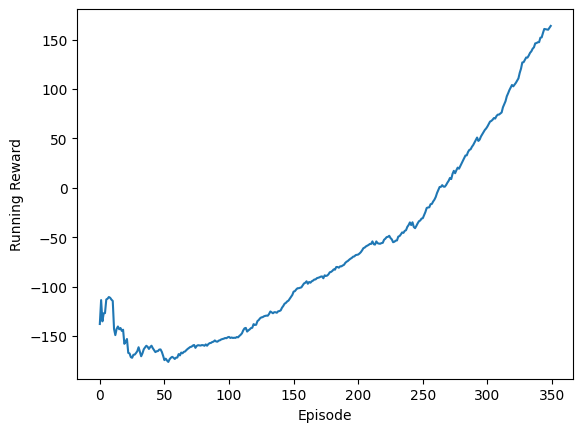

Episode 360, Running Reward: 172.74, Epsilon: 0.050
Episode 370, Running Reward: 184.12, Epsilon: 0.050
Episode 380, Running Reward: 196.32, Epsilon: 0.050
Solved LunarLander at episode 388!


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import time
!pip install swig
!pip install "gymnasium[box2d]"

# Environment
env = gym.make("LunarLander-v3", continuous=False)

num_actions = env.action_space.n
state_shape = env.observation_space.shape[0]

print(f"Actions: {num_actions}, State shape: {state_shape}")

# Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Q Network
class QModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, num_actions):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_sizes[0]))
        layers.append(nn.ReLU())
        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], num_actions))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def create_q_models(input_dim, layer_sizes, num_actions, do_target=False):
    model = QModel(input_dim, layer_sizes, num_actions)
    if do_target:
        target = QModel(input_dim, layer_sizes, num_actions)
        target.load_state_dict(model.state_dict())
        target.eval()
        return model, target
    return model

# Hyperparameters
layer_sizes = [128, 128]
batch_size = 64
gamma = 0.99
epsilon_max = 1.0
epsilon_min = 0.05
epsilon_greedy_frames = 50_000
epsilon_interval = epsilon_max - epsilon_min
max_steps_per_episode = 1000
update_after_actions = 4
update_target_network = 1000
max_memory_length = 50_000
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialize
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model, model_target = create_q_models(state_shape, layer_sizes, num_actions, do_target=True)
model.to(device)
model_target.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
memory = ReplayMemory(max_memory_length)


# Training loop
running_reward_history = []
episode_reward_history = []
frame_count = 0
episode_count = 0
epsilon = epsilon_max

tic = time.time()

while True:
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    episode_reward = 0

    for t in range(max_steps_per_episode):
        frame_count += 1

        # Epsilon decay
        if frame_count < epsilon_greedy_frames:
            epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
            epsilon = epsilon_min

        # Epsilon-greedy action
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = model(state.unsqueeze(0))
                action = torch.argmax(q_values).item()

        # Step environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward_tensor = torch.tensor(reward, dtype=torch.float32, device=device)
        action_tensor = torch.tensor(action, dtype=torch.long, device=device)
        done_tensor = torch.tensor(done, dtype=torch.float32, device=device)

        memory.push(state, action_tensor, next_state_tensor, reward_tensor, done_tensor)
        state = next_state_tensor

        # Update network
        if frame_count % update_after_actions == 0 and len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            # Compute target using target network
            with torch.no_grad():
                next_q_values = model_target(next_state_batch)
                max_next_q_values, _ = torch.max(next_q_values, dim=1)
                target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            optimizer.zero_grad()
            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)
            loss = loss_function(q_action, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        # Update target network periodically
        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        if done:
            break

    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if episode_count % 10 == 0:
        print(f"Episode {episode_count}, Running Reward: {running_reward:.2f}, Epsilon: {epsilon:.3f}")

    # Plot progress every 50 episodes
    if episode_count % 50 == 0:
        plt.figure()
        plt.plot(running_reward_history)
        plt.xlabel("Episode")
        plt.ylabel("Running Reward")
        plt.show()
        plt.close("all")

    # Solving condition
    if running_reward >= 200:
        print(f"Solved LunarLander at episode {episode_count}!")
        break